In [ ]:
from google.colab import drive
drive.mount('/content/drive') # se connecter à mon google drive


Mounted at /content/drive


In [ ]:
!ls
import os 
#os.listdir('/content/drive/MyDrive') # afficher le contenu du dossier drive/MyDrive
!ls '/content/drive/MyDrive/Colab Notebooks/'
%cd '/content/drive/MyDrive/Colab Notebooks/'
!ls

# Test technique *Anomaly Detection*

## Introduction

### Contexte

Une des problématiques industrielles fréquemment rencontrée est la détection des erreurs et non-conformités sur une chaine.

Plusieurs approches sont possibles pour répondre à cette problématiques avec notamment:

* L'utilisation d'un model classique de classification en se basant sur un dataset labelisé par des experts
* L'utilisation d'un model non-supervisé de type autoencoder.



### Traitement

Le traitement est divisé en deux parties.

**Première partie**

La première partie concerne l'entrainement du model. De la prise en main des données jusqu'à l'entrainement final, en passant par la définition du model d'autoencoder.

**Deuxième partie**

La deuxième partie permet d'aller plus loin en modifiant notre pipeline solution.
Le principe de l'autoencoder est de réduire la dimension de l'input puis de recréer cet input. Dans le cas de notre image notre donnée passe par 3 états:

1. Une Image
2. Un Vecteur (post encoder)
3. Une Image (post decoder)

Le but de cette partie est de couper le model en deux, en ne conservant que l'encoder. Donc on entraine un autoencoder, on utilise que l'encodeur qui génère un vecteur et on fait de la clusterisation à partir de ces vecteurs.

## Code

## Première partie

#### import

In [ ]:
import os

import cv2 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import math
from tensorflow.keras.utils import Sequence

import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random


#### Dataset

In [ ]:
def get_paths(directory: str) -> list:
    """ This function is used to retrieve all the images' path from a given directory.

    Our images are stored on a disk. This function is used to check all the file in a given folder and retrieve the path
    of the image files and store it into a list.

    :param directory: The path of the directory where our dataset is stored.
    :return: List with all the images' path.
    """

    paths = []
    extensions = [".jpeg", ".png", ".jpg", ".bmp"]
    for directory_path, _, filenames in os.walk(directory):
        image_paths = [
            file for file in filenames
            if any(file.lower().endswith(extension) for extension in extensions)
        ]
        for filename in image_paths:
            paths.append(os.path.join(directory_path, filename))

    return paths

In [ ]:
def split_dataset(train_directory: str, test_directory: str, validation_part: float, random_state: int):
    """ Function used to get Train / Validation / Test datasets.

    When training a model, we use several datasets. One to train, one to test during training and one to test in a
    "production" environment. This function is used to split and generate those datasets.

    :param train_directory: Path of the directory where images used for train and validation dataset are stored.
    :param test_directory: Path of the directory where images used for test dataset are stored.
    :param validation_part: Percentage of images used to generate validation dataset.
    :param random_state: A "version" of a random distribution of our images.
    :return: A list of paths used for train dataset.
    :return: A list of paths used for validation dataset.
    :return: A list of paths used for test dataset.
    """

    train_valid_paths = get_paths(train_directory)

    split_result = train_test_split(
        train_valid_paths, # x
        train_valid_paths, # y
        test_size=validation_part,
        random_state=random_state
    )

    train_reference_paths = split_result[0] # x_train
    valid_reference_paths = split_result[1] # x_test
    train_input_paths = split_result[2] # y_train
    valid_input_paths = split_result[3] # y_test

    test_reference_paths = []
    test_input_paths = []

    if test_input_paths:
        test_paths = get_paths(test_directory)
        test_reference_paths = test_paths
        test_input_paths = test_paths

    return (
        train_reference_paths,
        valid_reference_paths,
        train_input_paths,
        valid_input_paths,
        test_reference_paths,
        test_input_paths
    )

In [ ]:

train_paths, valid_paths, train_input_paths, valid_input_paths, test_reference_paths, test_input_paths = \
    split_dataset("/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/train/images/", 
              "/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/good//images/", 
              0.2, 42)


In [ ]:
########################### GOOD   ###################################################################



#Size of our input images
SIZE = 128 # 64

#############################################################################
#Define generators for training, validation and also anomaly data.

batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
anomaly_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/train/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input')

valid_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/validation/', # cloud_data_parasited
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input')

test_good_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/good/', # cloud_data_parasited
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    ) 

test_anomaly_generator = anomaly_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/glue/', # cloud_data_parasited
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    ) 

############################################### fin good ###################################################

Found 185 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Found 32 images belonging to 1 classes.
Found 19 images belonging to 1 classes.


#### Model

In [ ]:
def simple_autoencoder():
    """ Definition of a simple autoencoder.



    :return: Keras Model.
    """

    # à compléter
    ################### add ######################
    
    ### simple autoencoder ### 
    """
    input_shape = (SIZE, SIZE,1)
    #Encoder
    model = Sequential()
    model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    encoder = model

    #Decoder
    model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    decoder = model

    autoencoder = decoder
    """
    ### fin simple autoencoder ###
    ##############################

    ### deep autoencoder ### 

    input_shape = (SIZE, SIZE,1)

    #Encoder
    model = Sequential()
    model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D((SIZE/4), (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D((SIZE/8), (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    encoder = model

    #Decoder
    model.add(Conv2D((SIZE/8), (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D((SIZE/4), (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    decoder = model
    autoencoder = decoder
    ### fin deep autoencoder ###
    
    ################### fin add ######################

    return encoder, decoder, autoencoder
    

In [ ]:
(encoder, decoder, autoencoder) = simple_autoencoder()

In [ ]:
opt = Adam(learning_rate=1e-03, decay=1e-03 / 300)
autoencoder.compile(loss="mse", optimizer=opt)
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

#### Training

In [ ]:
callbacks = []
monitor = "val_loss"

In [ ]:
early_stopping = EarlyStopping(
  monitor=monitor,
  patience=50,
  verbose=1,
  restore_best_weights=True
)
callbacks.append(early_stopping)

In [ ]:
reduce_lr = ReduceLROnPlateau(
  monitor=monitor,
  factor=0.5,
  patience=20,
  min_lr=1e-6,
  verbose=1
)
callbacks.append(reduce_lr)

In [ ]:
model_checkpoint = ModelCheckpoint(
  "/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/model_checkpoint_leather_deep.h5",
  monitor=monitor,
  save_best_only=True,
  save_weights_only=True
)
callbacks.append(model_checkpoint)

In [ ]:
H = autoencoder.fit(
	train_generator,
	validation_data = valid_generator,
	callbacks=callbacks,
	epochs=100,
	batch_size=32,
	use_multiprocessing=True,
  workers=10,
)

Epoch 1/100
6/6 [==============================] - 75s 12s/step - loss: 0.0399 - val_loss: 0.0150 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 42s 6s/step - loss: 0.0107 - val_loss: 0.0060 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 40s 6s/step - loss: 0.0058 - val_loss: 0.0076 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 43s 6s/step - loss: 0.0042 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 44s 6s/step - loss: 0.0028 - val_loss: 0.0031 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 40s 6s/step - loss: 0.0025 - val_loss: 0.0032 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 42s 6s/step - loss: 0.0023 - val_loss: 0.0027 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 47s 7s/step - loss: 0.0022 - val_loss: 0.0026 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 43s 6s/step - loss: 0.0021 - val_loss: 0.0025 - lr: 0.0010
Epoch 10/

## Deuxième partie

Cette partie est beaucoup moins guidée. La seule indication est la consigne:

Le but de cette partie est de couper le model en deux, en ne conservant que l'encoder. Donc on entraine un autoencoder, on utilise que l'encodeur qui génère un vecteur et on fait de la clusterisation à partir de ces vecteurs.

Le candidat est libre dans sa réalisation et ne sera pas juger sur le résultat.

- Affichons le graph pour voir si le model s'est bien entrainé

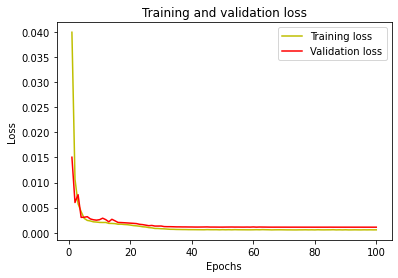

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

On remarque une les courbe d'erreur ne diminue plus significativement après 50 epochs d'entrainement. on peu dire que l'autoencoder s'est bien entrainé

Nous allons céer des lots

In [ ]:
train_generator.batch_index
data_batch = []  
img_num = 0
while img_num <= train_generator.batch_index:   
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

print(img_num)

6


In [ ]:
for i in range(0,img_num,1):
  print(len(data_batch[i])) 
  # on remarque que le dernier lot comtient 25 images

32
32
32
32
32
25


Nous allons tester une prediction avec chaccun un des lots

In [ ]:
"""
predicted_0 = autoencoder.predict(data_batch[0])  #Prediction avec le 1er lots d'images
predicted_1 = autoencoder.predict(data_batch[0])
predicted_2 = autoencoder.predict(data_batch[0])
predicted_3 = autoencoder.predict(data_batch[0])
predicted_4 = autoencoder.predict(data_batch[0])
predicted_5 = autoencoder.predict(data_batch[0]) #Prediction avec le 6ime lots d'images
"""

for i in range(0,img_num,1):
  code = "predicted_{i} = autoencoder.predict(data_batch[{i}]) ".format(i=i)
  exec(code)

# cela va générer predicted_0, predicted_1, predicted_2, ... predicted_5

1/1 [==============================] - 1s 676ms/step


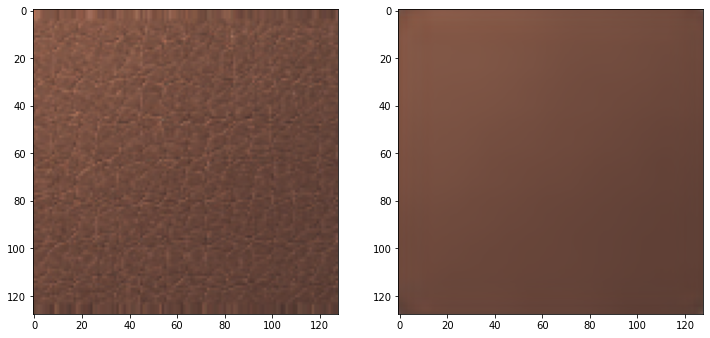

In [ ]:
# continuons avec predicted_0 
#comparons l'image réel et l'image reconstruit par l'autoencoder
image_number = random.randint(0, predicted_0.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted_0[image_number])
plt.show()

Maintenant, nous allons ajouter du bruit pour injecter des anomalie sur certaines de nos bonnes images afin que ces nouvelles images nous servent d'amages avec anomalie pendant l'analyse, cela nous sera utils pour définir les seuil des métriques

In [ ]:
import glob
uninfected_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/validation/images/*')
len(uninfected_file_paths)
#noise_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/noise/images/*')

60

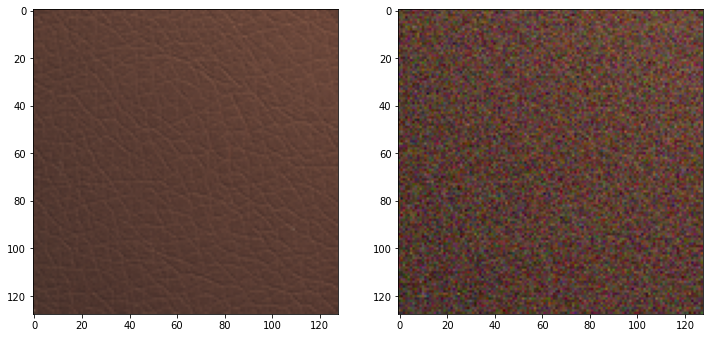

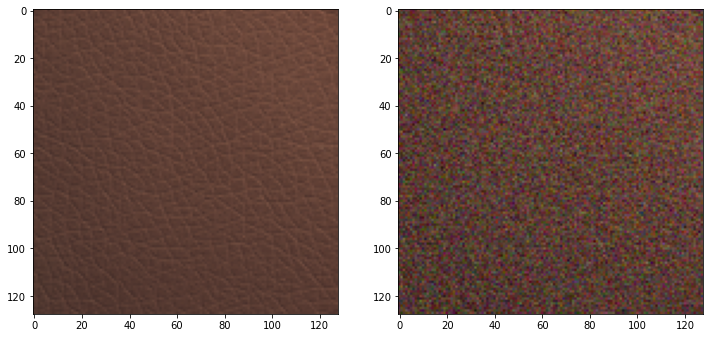

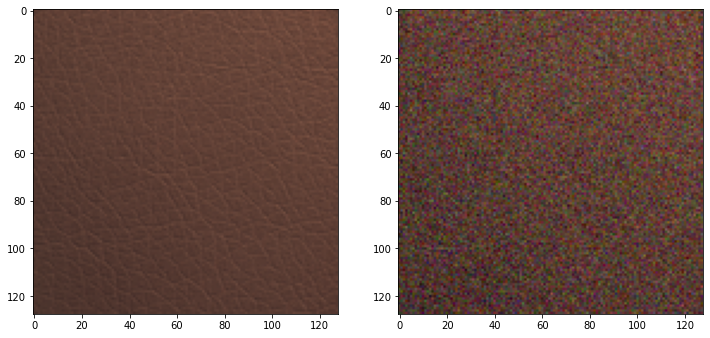

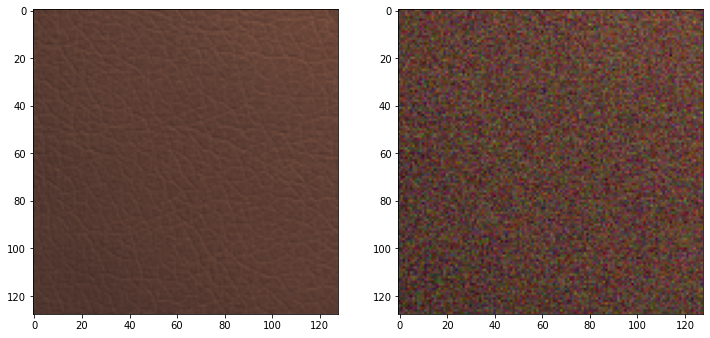

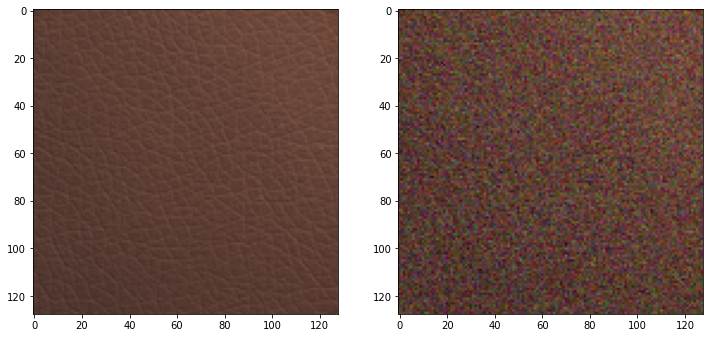

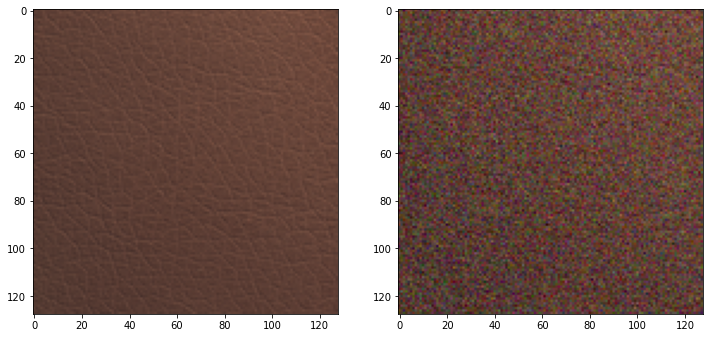

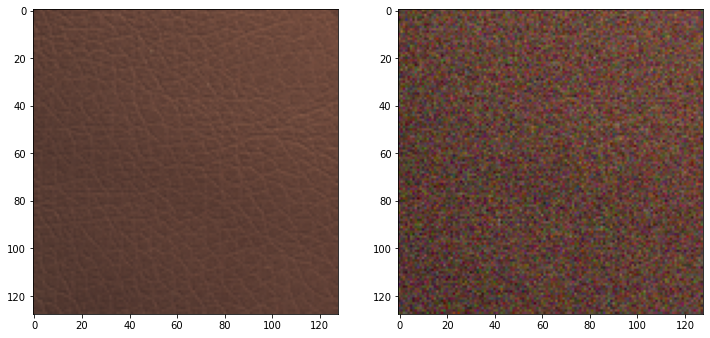

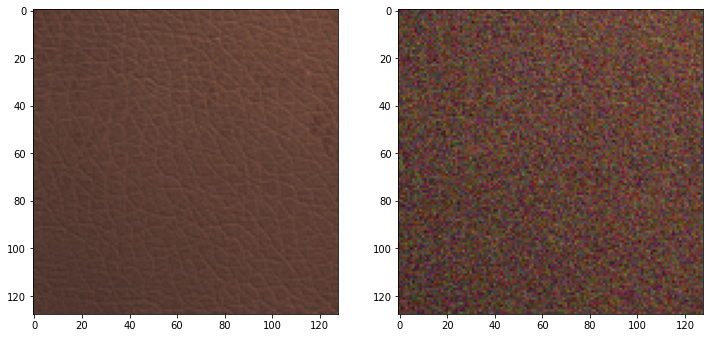

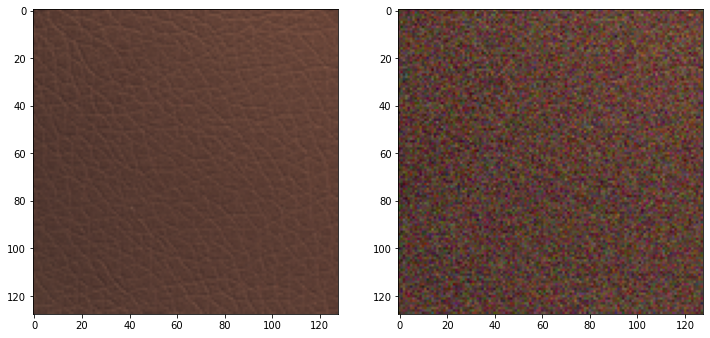

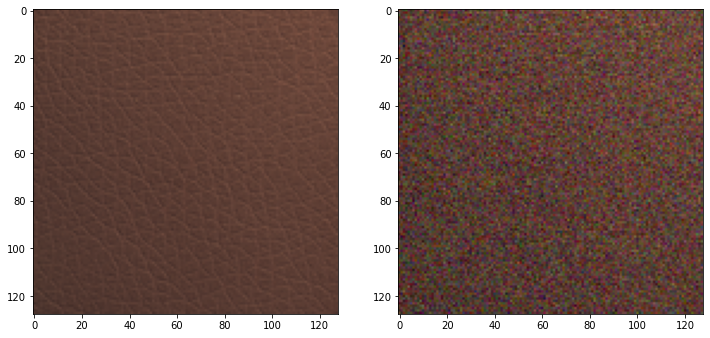

In [ ]:
import matplotlib.image
#uninfected_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/validation/images/*')

list_noise = []
for i in range(1,11,1):
  num=random.randint(0,len(uninfected_file_paths)-1)
  if num not in list_noise :
    img_path = uninfected_file_paths[num]
    img = cv2.imread(img_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img)
    img = Image.fromarray(img)
    img = np.array(img.resize((SIZE,SIZE), Image.ANTIALIAS))
    img = img / 255.
    #plt.imshow(img)

    noise_factor = 0.07
    img_noise = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape) 
    img_noise = np.clip(img_noise, 0., 1.) # 0,1
    #plt.imshow(img_noise)
    #dd = '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/cloud_data_noise/images/image_with_noise_{}.png'.format("3")
    dd = str(img_path).replace("validation", "noise" )
    matplotlib.image.imsave(dd, img_noise)
    #plt.savefig('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/cloud_data_noise/images/image_with_noise_{}.png'.format("1"))
    #cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/cloud_data_noise/images/image_with_noise_{}.png'.format("2"), img_noie)



    
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(img_noise)
    plt.show()


In [ ]:
# récupérons les erreurs de reconstitution avec les images de  validation et ceux contenant des anomalies

anomaly_noise_datagen = ImageDataGenerator(rescale=1./255)
noise_anomaly_generator = anomaly_noise_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/noise/', # cloud_data_parasited
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    ) 

validation_error = autoencoder.evaluate_generator(valid_generator)
anomaly_error = autoencoder.evaluate_generator(noise_anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

Found 9 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  if sys.path[0] == '':


Recon. error for the validation (normal) data is:  0.0011030554305762053
Recon. error for the anomaly data is:  0.005364276934415102


On remarque que l'anomaly_error est 5 fois superieur à la validation_error. Alors cette metrique peux nous etre util pour la detection d'anomalie

- créeons notre encoder en utilisant les poids l' autoencodeur précédent

In [ ]:
### si reseau simple ###
"""
encoder_model = Sequential()
encoder_model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=autoencoder.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()
"""
### fin si reseau simple ###


### si reseau profond ###
encoder_model = Sequential()
encoder_model.add(Conv2D((SIZE/2), (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=autoencoder.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D((SIZE/4), (3, 3), activation='relu', padding='same', weights=autoencoder.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D((SIZE/8), (3, 3), activation='relu', padding='same', weights=autoencoder.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()
### fin si reseau profond ###

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

- KDE (estimation de la densité du noyau)

In [ ]:
###################### KDE (estimation de la densité du noyau) ##################################
# Calcul du KDE avec sklearn
from sklearn.neighbors import KernelDensity


#recupérons la sortie encodée des images d'entrée = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Aplatissons la sortie de l'encodeur car KDE de sklearn prend des vecteurs 1D en entrée
encoder_output_shape = encoder_model.output_shape #  16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE sur les latent 
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


In [ ]:

#Calcul de l'erreur de densité et de reconstruction et calcule de leurs moyennes pour les bonnes et mauvaises images 

#Nous allons utiliser ces moyennes et sigma pour fixer des seuils
def calcul_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Créer une version compressée de l'image à l'aide de l'encodeur
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Aplatissons l'image compressée
        density = kde.score_samples(encoded_img)[0] # récupérons le score de densité pour la nouvelle image
        reconstruction = autoencoder.predict([[img]])
        reconstruction_error = autoencoder.evaluate([reconstruction],[[img]], batch_size = 1) # [0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error


train_batch = train_generator.next()[0]
anomaly_batch = noise_anomaly_generator.next()[0]

uninfected_values = calcul_density_and_recon_error(train_batch)
anomaly_values = calcul_density_and_recon_error(anomaly_batch)


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 45ms/step - loss: 0.0054


In [ ]:
print("type_data        ", ( "average_density",  "stdev_density" , "average_recon_error", "stdev_recon_error"))
print("uninfected_values", uninfected_values)
print("anomaly_values   ", anomaly_values) # il faut vérifier si les métrique des l'erreur sont mauvaises, sinon, il faudra aller régénérer notre autoencoder

type_data         ('average_density', 'stdev_density', 'average_recon_error', 'stdev_recon_error')
uninfected_values (2825.5597657655417, 0.46446160293346866, 0.0005972509219821903, 9.92310176440512e-05)
anomaly_values    (2808.757104493864, 0.4539235558348345, 0.00545173289719969, 4.896571537871602e-05)


Ici, on s'attend souvent à ce que la densité moyenne des anomalies soit significativement inférieur à celle des bonnes images. Mais dans ce cas précis, on remarque que la différence entre les densité moyennes n'est pas très significative; tout de même on à la densité moyenne des anomalies qui sont inférieur à la densité moyenne des bonnes images (2808.7 ~< 2825.5)

On s'attend aussi à ce que l'erreur moyen de reconstruction des anomalies soit significativement supérieur à celle des bonnes images. C'est le cas ici, on a bien 0.00545 >> 0.000597. 

On va donc reconnaitres nos anomalies en se basant sur ces deux métriques. 
Dans cet exemple, je prends les moyenne des erreurs des bonnes images comme seuil. Dans la pratique il faudra analyser plus en profondeur pour choisir un meilleur seuil sinon on risque de déclarer un peu trop de bonne image comme étant des anomalies. 
Le chois de ces seuil peu dépendre aussi du contexte et des coût liée aux faux positif et aux faux négatif. cela pourrai nous aider à ajuster notre seuil pour réponder au context de la mission. 


In [ ]:
uninfected_values[0]

2825.5597657655417

In [ ]:

def check_anomalie(img_path):
    density_threshold = uninfected_values[0]  # on se sert des métriques ci dessus pour définir les seuils 
    reconstruction_error_threshold = uninfected_values[2] # on se sert des métriques ci dessus pour définir les seuils 
    img = cv2.imread(img_path) 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.asarray(img)
    img = Image.fromarray(img)
    img = np.array(img.resize((SIZE,SIZE), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = autoencoder.predict([[img]])
    reconstruction_error = autoencoder.evaluate([reconstruction],[[img]], batch_size = 1) #[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("Cette image comporte une anmalie", "\n donc ce cuir comporte une anmalie" )
        
        
    else:
        print("Cette image est Bonne", "\n donc ce cuir est correct")

1/1 [==============================] - 0s 80ms/step - loss: 4.1633e-04
Cette image est Bonne 
 donc ce cuir est correct


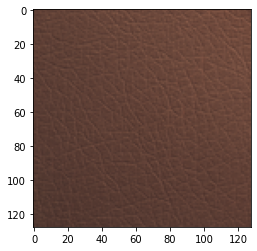

In [ ]:
# Image Normale verification
validation_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/validation/images/**')

num_valid=random.randint(0,len(validation_file_paths)-1) # 7
check_anomalie(validation_file_paths[num_valid])

1/1 [==============================] - 0s 44ms/step - loss: 0.0055
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


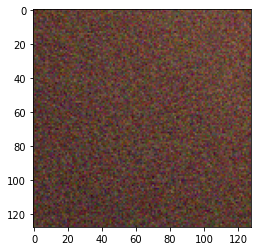

In [ ]:
# Image bruité verification
noise_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/train/good/noise/images/*')

num_noise=random.randint(0,len(noise_file_paths)-1)
check_anomalie(noise_file_paths[num_noise])

1/1 [==============================] - 0s 52ms/step - loss: 7.0651e-04
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


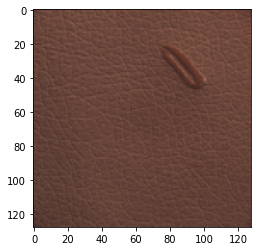

In [ ]:
# Image anomalie verification
anomalie_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/glue/images/*')

num_anomaly=random.randint(0,len(anomalie_file_paths)-1)
check_anomalie(anomalie_file_paths[num_anomaly])

1/1 [==============================] - 0s 68ms/step - loss: 9.9224e-04
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


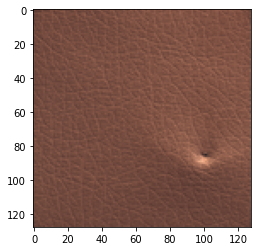

In [ ]:
# Image anomalie verification
anomalie_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/poke/*')

num_anomaly2=random.randint(0,len(anomalie_file_paths)-1)
check_anomalie(anomalie_file_paths[num_anomaly2])

1/1 [==============================] - 0s 55ms/step - loss: 9.4883e-04
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


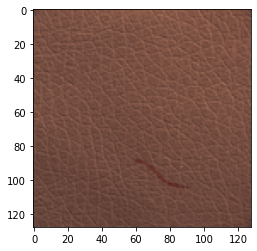

In [ ]:
# Image anomalie verification
anomalie_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/color/*')

num_anomaly3=random.randint(0,len(anomalie_file_paths)-1)
check_anomalie(anomalie_file_paths[num_anomaly3])

1/1 [==============================] - 0s 46ms/step - loss: 8.5240e-04
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


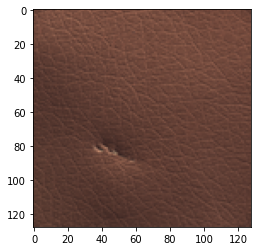

In [ ]:
# Image anomalie verification
anomalie_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/cut/*')

num_anomaly4=random.randint(0,len(anomalie_file_paths)-1)
check_anomalie(anomalie_file_paths[num_anomaly4])

1/1 [==============================] - 0s 49ms/step - loss: 7.4156e-04
Cette image comporte une anmalie 
 donc ce cuir comporte une anmalie


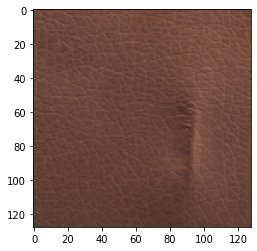

In [ ]:
# Image anomalie verification
anomalie_file_paths = glob.glob('/content/drive/MyDrive/Colab Notebooks/detection_anomaly/data_set_usine_pro/leather/test/fold/*')

num_anomaly5=random.randint(0,len(anomalie_file_paths)-1)
check_anomalie(anomalie_file_paths[num_anomaly5])

## Fin